**Import Modules**

In [1]:
import numpy as np
import scipy.sparse as ss
import pickle
from corextopic import corextopic as ct
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from ast import literal_eval
import joblib
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

2.14.0


**Import Data**

In [ ]:
data_anchored_corex = pd.read_csv("preprocessed_data.csv")
train_topics = pd.read_csv("Training Topics.csv")
df_anchored_corex = pd.DataFrame()

In [ ]:
data_words_anchored_corex = []
for x in data_anchored_corex['Clean']:
    data_words_anchored_corex.append(' '.join(literal_eval(x)))
keywords = []
for x in train_topics['Keys']:
    keywords.append(literal_eval(x))

**Feature Extraction**

In [ ]:
vectorizer_anchored_corex = CountVectorizer(stop_words='english', max_features=20000, binary=True)

In [ ]:
doc_word_anchored_corex = vectorizer_anchored_corex.fit_transform(data_words_anchored_corex)
doc_word_anchored_corex = ss.csr_matrix(doc_word_anchored_corex)

In [ ]:
words = list(np.asarray(vectorizer_anchored_corex.get_feature_names_out()))

**Anchored CorEx Model Training**

In [ ]:
#Train the CorEx topic model with 10 topics
topic_model_anchored_corex = ct.Corex(n_hidden=10, words=words, max_iter=1000, verbose=False, seed=2022)
topic_model_anchored_corex.fit(doc_word_anchored_corex, words=words, anchors = keywords, anchor_strength=3);

**Save Model and Extract Topics**

In [ ]:
pickle.dump(topic_model_anchored_corex, open('Anchored_CorEx_Train_model.sav', 'wb'))
topic_list_anchored_corex = topic_model_anchored_corex.get_topics()

**Visualize Topics**

In [ ]:
df_anchored_corex['Topics'] = topic_list_anchored_corex
df_anchored_corex.to_csv('Anchored_CorEx_topics.csv')

In [ ]:
# Print all topics from the CorEx topic model
anchored_corex_topics = topic_model_anchored_corex.get_topics()
for n,topic in enumerate(anchored_corex_topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: sound, quality, bass, good, great, price, clear, heavy, deep, amazing
1: music, microphone, mic, voice, listen, hear, speak, phone, talk, listening
2: battery, life, long, forever, hour, period, percentage, drain, usage, batter
3: touch, tap, pause, song, track, skip, sensor, double, change, pauseplay
4: control, touch, button, sensitive, sensor, volume, responsive, app, press, adjust
5: noise, cancel, cancellation, cancelation, background, block, active, feature, ambient, reduction
6: charge, long, fast, quickly, charger, case, charging, time, hold, cable
7: ear, size, tip, fit, stay, bud, fall, include, miss, large
8: use, connect, disconnect, device, bluetooth, leave, blue, work, easy, stop
9: cheap, expensive, inexpensive, pro, airpod, reasonable, wireless, air, beat, apple


**Aspect Labelling on Reviews**

In [ ]:
# import preprocessed review
data = pd.read_csv("preprocessed_data.csv")
aspect_list = [[],[],[],[],[],[],[],[],[],[]]
words_set = []
for x in data['Clean']:
    words_set.append(set(literal_eval(x)))

In [ ]:
# load trained CorEx model
model = pickle.load(open("Anchored_CorEx_Train_model.sav", 'rb'))

In [ ]:
# label
topic_list = []
for i, topic_words in enumerate(model.get_topics()):
      topic_list.append(set([words[0] for words in topic_words if words[1] > 0]))

In [ ]:
for words in words_set:
    for i,topic_words in enumerate(topic_list):
        if (words & topic_words):
            aspect_list[i].append(1)
        else:
            aspect_list[i].append(0)

for i in range(10):
    data['Topic ' + str(i)] = aspect_list[i]

In [ ]:
# save labelled data to excel file
data.to_csv('labelled_aspect.csv')

### Sentiment Analysis

**Import Data**

In [ ]:
 # import data
data = pd.read_csv('labelled_aspect.csv')

In [ ]:
data.head()

,Unnamed: 0.1,Unnamed: 0,product,review,Clean,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0,0,Samsung Galaxy Buds 2 Pro True Wireless Earbud...,"love these good audio, great battery life, noi...","['love', 'good', 'audio', 'great', 'battery', ...",1,0,1,0,0,1,0,0,0,0
1,1,1,Samsung Galaxy Buds 2 Pro True Wireless Earbud...,i used to the original galaxy pro buds and the...,"['use', 'original', 'galaxy', 'pro', 'bud', 'n...",1,0,0,0,0,0,0,1,1,1
2,2,2,Samsung Galaxy Buds 2 Pro True Wireless Earbud...,love these ear buds.,"['love', 'ear', 'bud']",0,0,0,0,0,0,0,1,0,0
3,3,3,Samsung Galaxy Buds 2 Pro True Wireless Earbud...,"i went from android to an iphone, and they sti...","['go', 'android', 'iphone', 'still', 'work']",0,0,0,0,0,0,0,0,1,0
4,4,4,Samsung Galaxy Buds 2 Pro True Wireless Earbud...,"sound quality is very good, base levels are am...","['sound', 'quality', 'good', 'base', 'level', ...",1,0,1,0,0,1,0,0,1,0


**Load Trained Skip Gram BiLSTM Model**

In [ ]:
!unzip Sentiment_sg_bilstm_w2v.sav.zip

Archive:  Sentiment_sg_bilstm_w2v.sav.zip
   creating: Sentiment_sg_bilstm_w2v.sav/assets/
 extracting: Sentiment_sg_bilstm_w2v.sav/fingerprint.pb  
  inflating: Sentiment_sg_bilstm_w2v.sav/keras_metadata.pb  
  inflating: Sentiment_sg_bilstm_w2v.sav/saved_model.pb  
   creating: Sentiment_sg_bilstm_w2v.sav/variables/
  inflating: Sentiment_sg_bilstm_w2v.sav/variables/variables.data-00000-of-00001  
  inflating: Sentiment_sg_bilstm_w2v.sav/variables/variables.index  


In [ ]:
# import trained skip gram bilstm model for sentiment analysis
sentiment_model = tf.keras.models.load_model("Sentiment_sg_bilstm_w2v.sav")

**Data Preprocessing**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# function for preprocessing review data
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
# preprocess review data
data.review = data.review.apply(lambda x: preprocess(x))

CPU times: user 4.58 s, sys: 22.9 ms, total: 4.6 s
Wall time: 4.65 s


In [ ]:
# remove unnecessary column and display some samples
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.sample(10)

,product,review,Clean,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
21233,Beats by Dr Dre Beats Fit Pro True Wireless N...,thing seem get occasion static think related b...,"['thing', 'seem', 'get', 'occasion', 'static',...",0,0,0,0,0,0,0,0,0,0
26003,Samsung Galaxy Buds Live True Wireless Earbud...,pugs ears going inside ear way comfortable,"['pug', 'ear', 'go', 'inside', 'ear', 'way', '...",0,0,0,0,0,0,0,1,0,0
88055,Sony WIC310 Wireless InEar Headphones Black,easy use stays charged long time sound quality...,"['easy', 'use', 'stay', 'charge', 'long', 'tim...",1,0,1,0,0,0,1,1,1,0
135976,Apple AirPods with Charging Case 2nd generati...,third purchase relative,"['third', 'purchase', 'relative']",0,0,0,0,0,0,0,0,0,0
63433,JLab Epic Air Sport ANC True Wireless Earbuds...,price icing cake,"['price', 'icing', 'cake']",1,0,0,0,0,0,0,0,0,0
132607,Apple AirPods 3rd generation with Lightning C...,excellent quality satisfied merchandise,"['excellent', 'quality', 'satisfied', 'merchan...",1,0,0,0,0,0,0,0,0,0
64401,JLab Epic Air Sport ANC True Wireless Earbuds...,sound quality sound quality gate really good a...,"['sound', 'quality', 'sound', 'quality', 'gate...",1,1,0,0,0,0,0,0,0,0
41164,Bose QuietComfort Earbuds II True Wireless No...,best set earbuds beats fits pro apple air pods...,"['well', 'set', 'earbud', 'beat', 'fit', 'pro'...",0,0,0,0,1,0,0,1,1,1
103249,JLab JBuds Air Sport True Wireless InEar Head...,always like quality sound research type use de...,"['always', 'quality', 'sound', 'research', 'ty...",1,0,0,0,0,0,0,0,1,0
62615,JLab Epic Air Sport ANC True Wireless Earbuds...,first set wireless earbuds really nothing compare,"['first', 'set', 'wireless', 'earbud', 'really...",0,0,0,0,0,0,0,0,0,1


**Load Trained Tokenizer for Skip Gram BiLSTM Model**

In [ ]:
# import trained tokenizer (for skip gram bilstm model)
with open('sg_bilstm_w2v_tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

**Sentiment Analysis Prediction**

In [ ]:
# function for sentiment prediction using trained sentiment analysis model and trained tokenizer
SEQUENCE_LENGTH = 300

def decode_sentiment(score):
    return 1 if score >= 0.5 else 0

def predict(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = sentiment_model.predict([x_test])[0]
    # Decode sentiment as 0 or 1
    label = decode_sentiment(score)

    return label

In [ ]:
SEQUENCE_LENGTH = 300

def decode_sentiment(score):
    return 1 if score >= 0.5 else 0

def batch_predict(texts):
    # Tokenize the texts
    sequences = tokenizer.texts_to_sequences(texts)
    x_test = pad_sequences(sequences, maxlen=SEQUENCE_LENGTH)

    # Predict using the entire batch
    scores = sentiment_model.predict(x_test)

    # Decode sentiment for the entire batch as 0 or 1
    labels = [decode_sentiment(score) for score in scores]

    return labels

In [ ]:
# predict the sentiment of the review
#data['predicted_sentiment'] = data['review'].apply(predict)
data['predicted_sentiment'] = batch_predict(data['review'])

4340/4340 [==============================] - 685s 157ms/step


**Save Results**

In [ ]:
data.to_csv('aspect_sentiment.csv')

In [4]:
data = pd.read_csv('aspect_sentiment.csv')

In [11]:
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,product,review,Clean,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,predicted_sentiment
0,Samsung Galaxy Buds 2 Pro True Wireless Earbud...,love good audio great battery life noise cance...,"['love', 'good', 'audio', 'great', 'battery', ...",1,0,1,0,0,1,0,0,0,0,1
1,Samsung Galaxy Buds 2 Pro True Wireless Earbud...,used original galaxy pro buds new galaxy pro b...,"['use', 'original', 'galaxy', 'pro', 'bud', 'n...",1,0,0,0,0,0,0,1,1,1,0
2,Samsung Galaxy Buds 2 Pro True Wireless Earbud...,love ear buds,"['love', 'ear', 'bud']",0,0,0,0,0,0,0,1,0,0,1
3,Samsung Galaxy Buds 2 Pro True Wireless Earbud...,went android iphone still work,"['go', 'android', 'iphone', 'still', 'work']",0,0,0,0,0,0,0,0,1,0,0
4,Samsung Galaxy Buds 2 Pro True Wireless Earbud...,sound quality good base levels amazing noise c...,"['sound', 'quality', 'good', 'base', 'level', ...",1,0,1,0,0,1,0,0,1,0,1


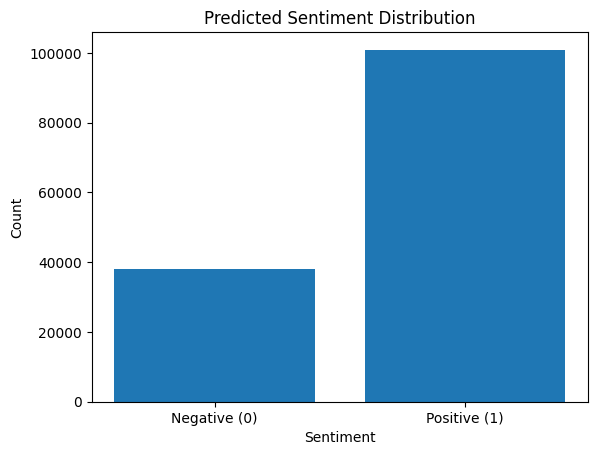

In [12]:
sentiment_counts = data['predicted_sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title("Predicted Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])  # Label the x-axis

# Show the plot
plt.show()

Product Ranking

In [22]:
product_lst = [
    'Samsung Galaxy Buds 2 Pro True Wireless Earbud Headphones Graphite',
    'Beats by Dr Dre  Beats Studio Buds Totally Wireless Noise Cancelling Earbuds  Black',
    'Beats by Dr Dre  Geek Squad Certified Refurbished Beats Fit Pro True Wireless Noise Cancelling InEar Headphones Black',
    'Beats by Dr Dre  Beats Fit Pro True Wireless Noise Cancelling InEar Earbuds Black',
    'Samsung  Galaxy Buds Live True Wireless Earbud Headphones Bronze',
    'Samsung  Galaxy Buds2 True Wireless Earbud Headphones  Phantom Black',
    'Bose  QuietComfort Earbuds II True Wireless Noise Cancelling InEar Headphones Triple Black',
    'Google  Pixel Buds ASeries True Wireless InEar Headphones  Olive',
    'JBL  Endurance Peak II True Wireless InEar Earbuds  Black',
    'Sony  EX155AP EX Series Wired InEar Headphones  Black',
    'JLab  Epic Air Sport ANC True Wireless Earbuds  Black',
    'JBL  Reflect Mini True Wireless Noise Cancelling InEar Earbuds Black',
    'Apple  EarPods with Lightning Connector  White',
    'Sony  MDREX14AP Wired Earbud Headphones  Black',
    'JLab  GO Air POP True Wireless InEar Headphones  Black',
    'Samsung  Geek Squad Certified Refurbished Galaxy Buds2 True Wireless Earbud Headphones Graphite',
    'Sony  WIC310 Wireless InEar Headphones  Black',
    'Soundcore by Anker Life Note E Earbuds True Wireless InEar Headphones  Black',
    'Jabra  Elite 85t True Wireless Advanced Active Noise Cancelling Earbuds  Titanium Black',
    'JLab  JBuds Air Sport True Wireless InEar Headphones  Black',
    'JLab  JBuds Pro Signature Wireless Earbud Headphones  Black',
    'JLab  Fit Sport Fitness Earbuds Wireless InEar Headphones  Black',
    'JLab  GO Air True Wireless InEar Headphones  Navy/Black',
    'JVC  Gumy Plus Wired Earbud Headphones  Red',
    'Apple  AirPods 3rd generation with Lightning Charging Case  White',
    'Apple  AirPods with Charging Case 2nd generation  White'
]

In [23]:
# create separate dataframe for every different products and map using dictionary
product_dataframes = {}
for product_name in product_lst:
    product_df = data[data['product'] == product_name]
    product_dataframes[product_name] = product_df

Compute Probability of Positive Sentiment in Each Topic

The product with highest probability of positive sentiment for that particular topic will ranked as first

In [24]:
def compute_probability(df):
    df = df.reset_index(drop = True)
    df = df.drop(['product', 'review', 'Clean'], axis = 1)
    prob_list = []
    for i in range(10):
        count = 0
        for j in range(len(df)):
            # if both particular topic and positive sentiment exist:
            if df[f'Topic {i}'][j] == 1 and df['predicted_sentiment'][j] == 1:
                count += 1
        # compute probability
        ans = count / df[f'Topic {i}'].value_counts()[1]
        prob_list.append(ans)
        
    return prob_list

In [26]:
# compute probabilities of positive sentiment for each topic and map using dictionary
product_probabilities = {}

for product_name, product_df in product_dataframes.items():
    probabilities = compute_probability(product_df)
    product_probabilities[product_name] = probabilities

In [27]:
def get_nth_element(product_probabilities, n):
    return product_probabilities[n]

In [28]:
# rank top 5 products for each topic
top_5_products_dict = {}

# Iterate through 10 topics and rank the products for each element
for n in range(10):
    # Sort the product_probabilities dictionary based on the nth element in each list
    sorted_product_probabilities = dict(sorted(product_probabilities.items(), key=lambda item: get_nth_element(item[1], n), reverse=True))
    
    # Get the top 5 products with the highest nth element
    top_5_products = list(sorted_product_probabilities.keys())[:5]
    
    # Store the top 5 products in the dictionary
    top_5_products_dict[f'Topic {n}'] = top_5_products

Visualize Results

In [29]:
# Print the top 5 products for each element with probability
for n in range(10):
    print(f"Top 5 products for Topic {n+1}:")
    for i, product in enumerate(top_5_products_dict[f'Topic {n}']):
        print(f"{i+1}. {product}: {product_probabilities[product][n]}")
        print()

Top 5 products for Topic 1:
1. Apple  AirPods with Charging Case 2nd generation  White: 0.9372659176029963

2. Apple  AirPods 3rd generation with Lightning Charging Case  White: 0.9341372912801484

3. Apple  EarPods with Lightning Connector  White: 0.9020044543429844

4. Beats by Dr Dre  Beats Fit Pro True Wireless Noise Cancelling InEar Earbuds Black: 0.8844282238442822

5. Samsung  Galaxy Buds2 True Wireless Earbud Headphones  Phantom Black: 0.8835396607060981

Top 5 products for Topic 2:
1. Apple  AirPods with Charging Case 2nd generation  White: 0.8364485981308412

2. Apple  AirPods 3rd generation with Lightning Charging Case  White: 0.8363636363636363

3. Apple  EarPods with Lightning Connector  White: 0.808695652173913

4. Samsung  Galaxy Buds Live True Wireless Earbud Headphones Bronze: 0.7751937984496124

5. JBL  Reflect Mini True Wireless Noise Cancelling InEar Earbuds Black: 0.7529411764705882

Top 5 products for Topic 3:
1. Apple  AirPods 3rd generation with Lightning Chargi